# Linear Regression (NumPy Implementation)

This notebook demonstrates linear regression implemented from scratch using NumPy.  
It shows the full computation pipeline: from cost calculation (Mean Squared Error) to gradient descent updates.  
This approach exposes the underlying mathematics and complements the theory notes in `theory/linear_regression_math.md`.

## Scenario: House Price Prediction

We use a synthetic dataset representing **houses with various features**.  

**Features include:**
- Number of bedrooms
- Size in square meters
- Age of the house
- Distance to city center
- Number of floors

**Target variable:**
- House price in thousands of dollars

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Helper Function: Generate Synthetic Data

In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def generate_house_data(m=2000, random_state=42):
    """
    Generate synthetic house price data with both raw and scaled features.
    
    Returns:
        df_raw : DataFrame with raw features and actual price
        X_scaled : np.ndarray of standardized features
        y_scaled : np.ndarray of target using scaled features and weights (0-1)
    """
    np.random.seed(random_state)
    
    # Generate raw features
    bedrooms = np.random.randint(1, 6, m)
    size = np.random.randint(30, 300, m)
    age = np.random.randint(0, 100, m)
    distance = np.random.randint(1, 30, m)
    floors = np.random.randint(1, 3, m)

    X_raw = np.column_stack([bedrooms, size, age, distance, floors])
    
    # ---------- Dataset 1: actual house prices ----------
    # Realistic weights and bias for raw features
    raw_weights = np.array([50000, 3000, -1000, -5000, 10000])
    raw_bias = 50000
    
    # Compute actual prices
    y_raw = np.dot(X_raw, raw_weights) + raw_bias
    
    df_raw = pd.DataFrame(
        data=np.column_stack([X_raw, y_raw]),
        columns=['bedrooms', 'size', 'age', 'distance', 'floors', 'price']
    )
    
    # ---------- Dataset 2: scaled features ----------
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)
    
    # Scaled weights and bias (0-1 range)
    scaled_weights = np.array([0.05, 0.3, -0.02, -0.1, 0.01])
    scaled_bias = 0.5
    
    # Compute target for scaled features
    y_scaled = np.dot(X_scaled, scaled_weights) + scaled_bias
    
    return df_raw, X_scaled, y_scaled

## Linear Regression - Example Scenario

### Generate Synthetic Data

In [3]:
df, X, y = generate_house_data(m = 2000, random_state = 42)

In [4]:
X

array([[ 0.70498146,  0.33050457, -0.45090498, -0.12184273, -1.00803226],
       [ 1.40402108, -1.6140622 , -1.66829801, -0.71999066, -1.00803226],
       [ 0.00594184,  0.04338733, -0.79873156,  1.43334188, -1.00803226],
       ...,
       [-1.39213741, -0.21762834, -0.7639489 ,  1.55297147,  0.99203175],
       [ 1.40402108, -1.49660515, -1.04221017, -0.71999066, -1.00803226],
       [ 0.00594184,  1.13965316,  1.35779322, -1.67702735,  0.99203175]])

### Understanding Data

In [5]:
df.head()

,bedrooms,size,age,distance,floors,price
0,4,189,37,14,1,720000
1,5,40,2,9,1,383000
2,3,167,27,27,1,549000
3,5,107,55,15,1,501000
4,5,106,89,12,1,479000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   bedrooms  2000 non-null   int32
 1   size      2000 non-null   int32
 2   age       2000 non-null   int32
 3   distance  2000 non-null   int32
 4   floors    2000 non-null   int32
 5   price     2000 non-null   int32
dtypes: int32(6)
memory usage: 47.0 KB


In [7]:
df.describe()

,bedrooms,size,age,distance,floors,price
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2.000000e+03
mean,2.991500,163.675500,49.96350,15.018500,1.504000,5.805855e+05
std,1.430892,76.642914,28.75715,8.361227,0.500109,2.468645e+05
min,1.000000,30.000000,0.00000,1.000000,1.000000,-9.000000e+03
25%,2.000000,97.000000,25.00000,8.000000,1.000000,3.830000e+05
50%,3.000000,164.000000,51.00000,15.000000,2.000000,5.725000e+05
75%,4.000000,229.250000,75.25000,22.000000,2.000000,7.790000e+05
max,5.000000,299.000000,99.00000,29.000000,2.000000,1.178000e+06


### NumPy Implementation

The Mean Squared Error (MSE) cost function is defined as:  

$$
J(w,b) = \frac{1}{2m} \sum_{i=1}^m (\hat{y}^{(i)} - y^{(i)})^2
$$

In [8]:
def compute_cost(X, y, w, b):
    """
    Compute the Mean Squared Error (MSE) cost for linear regression.

    Parameters:
        X : np.ndarray
            Feature matrix of shape (m, n), where m is the number of examples.
        y : np.ndarray
            True target values of shape (m,).
        w : np.ndarray
            Weight vector of shape (n,).
        b : float
            Bias term.

    Returns:
        cost : float
            Average MSE cost over all examples.
    """
    m = X.shape[0]
    predictions = np.dot(X, w) + b
    cost = (1/(2*m)) * np.sum((predictions - y)**2)
    return cost

In [9]:
w_initial = np.zeros(5)
b_initial = 0.0
compute_cost(X, y, w_initial, b_initial)

0.17709551803102222

This output represents the initial cost of the linear regression model when all weights and biases are set to zero and no training has been done yet.

Gradients:

$$
\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^m \big( \hat{y}^{(i)} - y^{(i)} \big) x_j^{(i)}
$$

$$
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m \big( \hat{y}^{(i)} - y^{(i)} \big)
$$

Gradient update:
$$
w_j := w_j - \alpha \frac{\partial J}{\partial w_j}, \quad
b := b - \alpha \frac{\partial J}{\partial b}
$$

In [10]:
def gradient_descent(X, y, w, b, alpha, num_iters):
    """
    Perform gradient descent to optimize weights and bias for linear regression.

    Parameters:
        X : np.ndarray
            Feature matrix of shape (m, n), where m is the number of examples.
        y : np.ndarray
            True target values of shape (m,).
        w : np.ndarray
            Initial weight vector of shape (n,).
        b : float
            Initial bias term.
        alpha : float
            Learning rate for gradient updates.
        num_iters : int
            Number of iterations to run gradient descent.

    Returns:
        w : np.ndarray
            Optimized weight vector after gradient descent.
        b : float
            Optimized bias term after gradient descent.
        cost_history : list of float
            Recorded cost at each iteration.
    """
    m = X.shape[0]
    cost_history = []
    
    for i in range(num_iters):
        predictions = np.dot(X, w) + b
        error = predictions - y
        
        # Compute gradients
        w_grad = (1/m) * np.dot(X.T, error)
        b_grad = (1/m) * np.sum(error)
        
        # Update weights and bias
        w -= alpha * w_grad
        b -= alpha * b_grad
        
        # Compute and store cost
        cost = compute_cost(X, y, w, b)
        cost_history.append(cost)
        
        if i % 100 == 0 or i == num_iters-1:
            print(f"{'Iteration':<10}: {_:<4} | {'Cost':<5}: {cost:<4.6f}")
    
    return w, b, cost_history

In [11]:
w_initial = np.zeros(5)
b_initial = 0.0

w_final, b_final, cost_hist = gradient_descent(X, y, w_initial, b_initial, 0.0005, 3000)

print("Final Parameters:")
print(f"w: {w_final}")
print(f"b: {b_final:.4f}")

Iteration : 0.17709551803102222 | Cost : 0.176918
Iteration : 0.17709551803102222 | Cost : 0.160004
Iteration : 0.17709551803102222 | Cost : 0.144709
Iteration : 0.17709551803102222 | Cost : 0.130878
Iteration : 0.17709551803102222 | Cost : 0.118371
Iteration : 0.17709551803102222 | Cost : 0.107060
Iteration : 0.17709551803102222 | Cost : 0.096831
Iteration : 0.17709551803102222 | Cost : 0.087581
Iteration : 0.17709551803102222 | Cost : 0.079215
Iteration : 0.17709551803102222 | Cost : 0.071650
Iteration : 0.17709551803102222 | Cost : 0.064807
Iteration : 0.17709551803102222 | Cost : 0.058619
Iteration : 0.17709551803102222 | Cost : 0.053023
Iteration : 0.17709551803102222 | Cost : 0.047961
Iteration : 0.17709551803102222 | Cost : 0.043383
Iteration : 0.17709551803102222 | Cost : 0.039243
Iteration : 0.17709551803102222 | Cost : 0.035498
Iteration : 0.17709551803102222 | Cost : 0.032111
Iteration : 0.17709551803102222 | Cost : 0.029048
Iteration : 0.17709551803102222 | Cost : 0.026277


After running gradient descent, the output shows the optimized weights and bias learned by the binary logistic regression model. These final parameters are what the model will use to make predictions, and they can be compared against the initial zero values to see how the training process adjusted them.

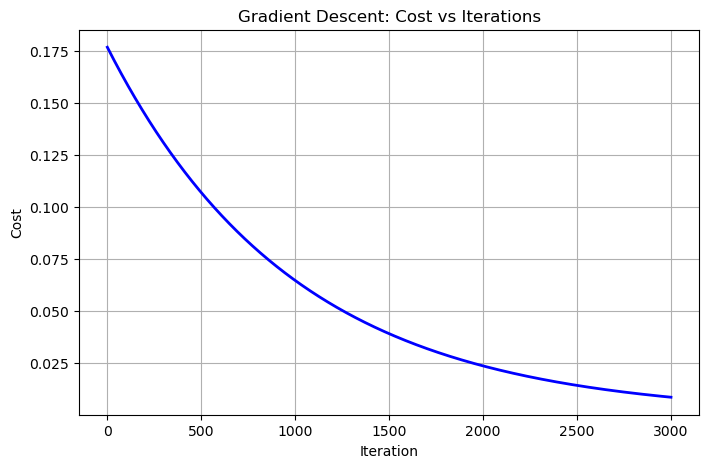

In [12]:
iterations = list(range(len(cost_hist)))  # x-axis
costs = cost_hist                         # y-axis

plt.figure(figsize = (8, 5))
plt.plot(iterations, costs, color = 'blue', linewidth = 2)
plt.title("Gradient Descent: Cost vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

The cost curve drops quickly at the start, showing that gradient descent makes big improvements early on. Around iteration ~1000, there’s an elbow where the cost still decreases but at a much slower rate, meaning the model is approaching its optimal parameters and further learning gives diminishing returns.

### Model Performance

In [13]:
# Prediction Function for Linear Regression
def predict(X, w, b):
    """
    Compute predicted values for a regression task using linear regression.

    Parameters:
        X : np.ndarray
            Feature matrix (m examples × n features)
        w : np.ndarray
            Weight vector learned from training
        b : float
            Bias term learned from training

    Returns:
        y_pred : np.ndarray
            Predicted continuous values for each example
    """
    # Compute the linear combination z = X·w + b
    y_pred = np.dot(X, w) + b
    
    return y_pred

In [14]:
# Generate predictions using the trained linear regression model
y_pred = predict(X, w_final, b_final)

# Compute Mean Squared Error
mse = np.mean((y_pred - y)**2)
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Squared Error (MSE): 0.02


Using the final trained weights and bias, the model generates predictions which are compared to the true values using the evaluation metric of mean squared error (MSE). The result shows that the model achieves an MSE of 0.02, indicating a close fit between predicted and actual values.